In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm

from twinLab import *

In [2]:
parameters = pd.read_csv('parameters.csv')
n_samples = parameters.shape[0]

In [3]:
model_output = []
for i in range(n_samples):
    s = pd.read_csv('samples/sample_{}.csv'.format(i))[['temperature', 'desorption_rate']]
    model_output.append(s)

In [4]:
grid_projection = Linear1dProjection()
grid, samples_grid = grid_projection.project(model_output)

In [5]:
normaliser = Normaliser(samples_grid)
samples_grid_normalised = normaliser.transform()

In [6]:
#lamb = 50
#mkl = 24
#projection = Matern32Projection(lamb, mkl)

#projection.fit(grid)
#theta, residuals = projection.project(samples_grid)

In [7]:
#m = 24
#projection = SVDProjection(m)
#projection.fit(samples_grid_normalised)
#projection.save('svd_projection.p')

In [8]:
projection = SVDProjection().load('svd_projection.p')

In [9]:
theta, residuals = projection.project(samples_grid_normalised)

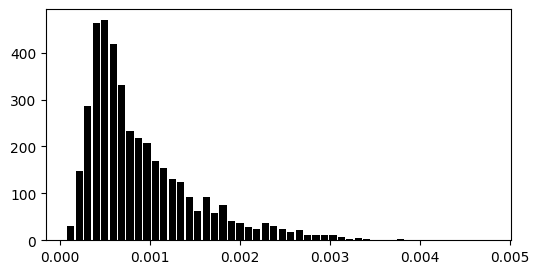

In [12]:
plt.figure(figsize=(6,3))
plt.hist(residuals, bins=50, color='k', width=0.00008)
#plt.savefig('SVD_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

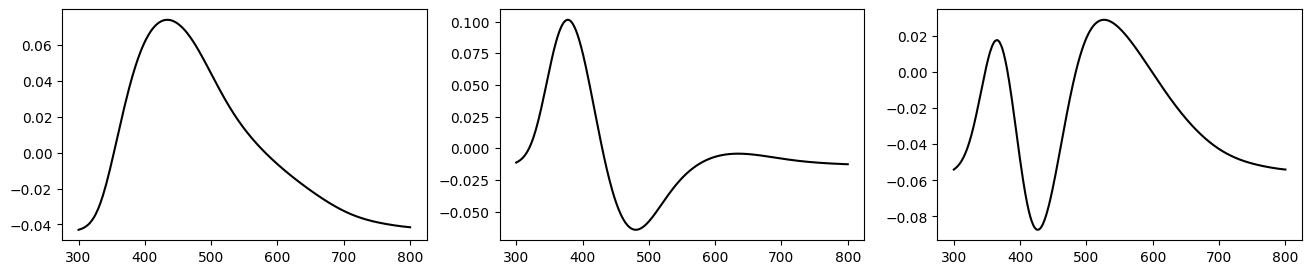

In [13]:
fig, ax = plt.subplots(figsize=(16,3), nrows=1, ncols=3)

ax[0].plot(grid, projection.u[:,0], color='k')
ax[1].plot(grid, projection.u[:,1], color='k')
ax[2].plot(grid, projection.u[:,2], color='k')

#plt.savefig('SVD_modes.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
model = IndependentMultiGPModel(parameters.values, theta, run_setup=False)

In [15]:
#iterations = 200
#model.train(iterations)

In [16]:
model.load_state_dict('multi_gp.p')

/home/mikkel/venv/twinlab/lib/python3.8/site-packages/linear_operator/utils/linear_cg.py:318: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.09572269022464752 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/mikkel/venv/twinlab/lib/python3.8/site-packages/linear_operator/utils/linear_cg.py:318: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.02584046684205532 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/mikkel/venv/twinlab/lib/python3.8/site-packages/linear_operator/

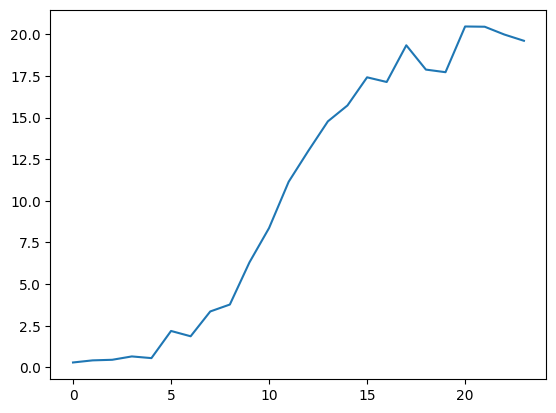

In [17]:
plt.plot(model.testing_norm)

In [18]:
#model.save_state_dict('multi_gp.p')

In [19]:
pipeline = Pipeline(output_modules=[model, projection, normaliser])

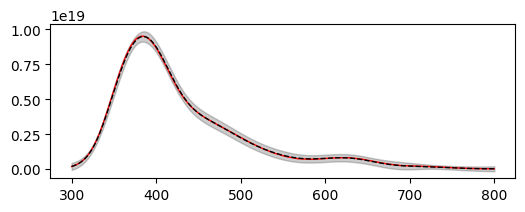

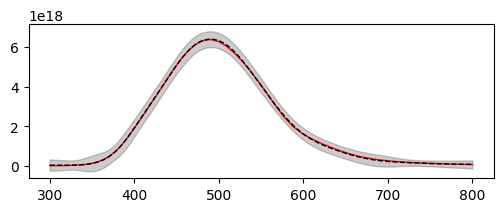

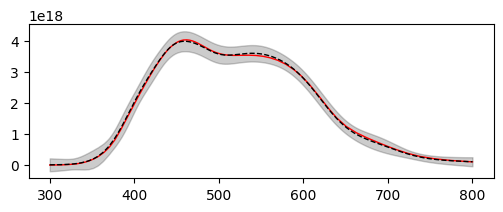

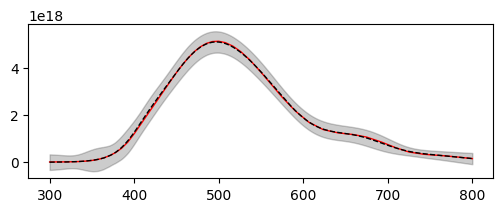

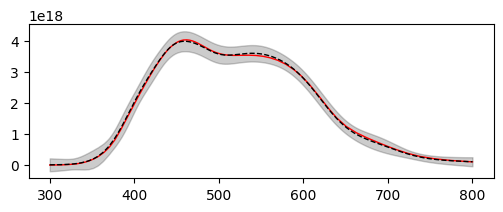

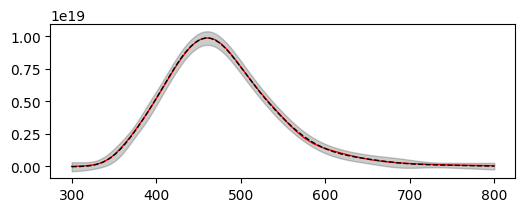

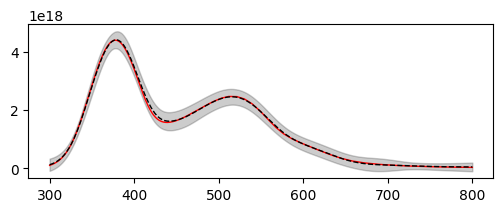

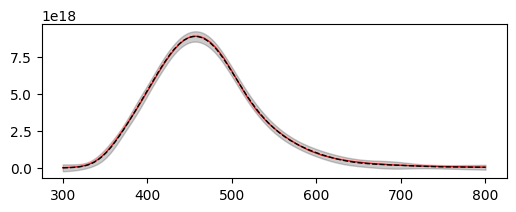

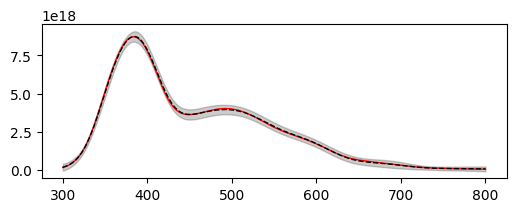

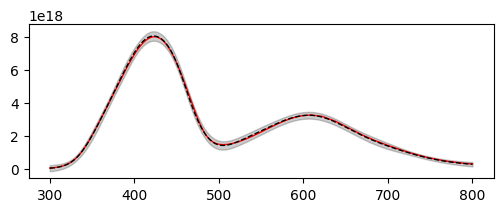

In [28]:
for i in range(10):
    
    idx = model.test_idx[np.random.randint(len(model.test_idx))]
    
    plt.figure(figsize=(6,2))
    plt.plot(grid, samples_grid[idx,:], c='r', linewidth=1)
    
    mean, stdev = pipeline.predict(parameters.values[idx,:])
    plt.plot(grid, mean, c='k', linewidth=1, linestyle='dashed')
    plt.fill_between(grid, mean-2*stdev, mean+2*stdev, alpha=0.2, color='k')

    plt.show()

In [23]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [29]:
def plot_parameters(E1, E2, E3, n1, n2):
    
    par = np.array([E1, E2, E3, n1, n2])
    mean, stdev = pipeline.predict(par)
    
    plt.figure(figsize=(8,3))
    plt.plot(grid, mean, c='k', linewidth=2, linestyle='dashed')
    plt.fill_between(grid, mean-2*stdev, mean+2*stdev, alpha=0.2, color='k')

    plt.show()

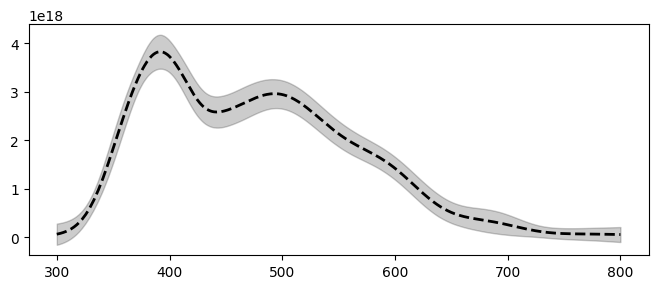

interactive(children=(FloatSlider(value=0.8, description='E1', max=2.4000000000000004, min=-0.8), FloatSlider(…

<function __main__.plot_parameters(E1, E2, E3, n1, n2)>

In [30]:
interact(plot_parameters, E1=0.8, E2=1.0, E3=1.5, n1=1e-3, n2=5e-4)